In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

In [15]:
df_final = pd.read_csv("../data/df_final.csv")
df_final['v2x_polyarchy_diff'] = abs(df_final['v2x_polyarchy_o'] - df_final['v2x_polyarchy_d'])
df_final['v2x_libdem_diff'] = abs(df_final['v2x_libdem_o'] - df_final['v2x_libdem_d'])
df_final['v2x_partipdem_diff'] = abs(df_final['v2x_partipdem_o'] - df_final['v2x_partipdem_d'])
df_final['v2x_delibdem_diff'] = abs(df_final['v2x_delibdem_o'] - df_final['v2x_delibdem_d'])
df_final['v2x_egaldem_diff'] = abs(df_final['v2x_egaldem_o'] - df_final['v2x_egaldem_d'])
df_final.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'
], inplace=True)

df_final.dropna(subset=['logallexports'], inplace=True)

In [16]:
df_final.columns

Index(['year', 'country_id_o', 'country_o', 'country_id_d', 'country_d',
       'contig', 'distcap', 'dist', 'comlang_off', 'comlang_ethno', 'comrelig',
       'pop_o', 'pop_d', 'gdp_o', 'gdp_d', 'gdpcap_o', 'gdpcap_d', 'fta_wto',
       'tradeflow_comtrade_o', 'tradeflow_comtrade_d', 'tradeflow_imf_o',
       'tradeflow_imf_d', 'IdealPointDistance', 'arms', 'tot_o', 'tot_d',
       'tgdp_ratio_o', 'tgdp_ratio_d', 'avgtradeflow', 'logtradeflow',
       'allexports', 'chemicalexports', 'consumerexports', 'foodexports',
       'machineryexports', 'manufacturesexports', 'logallexports',
       'logchemicalexports', 'logconsumerexports', 'logfoodexports',
       'logmachineryexports', 'logmanufacturesexports', 'v2x_polyarchy_diff',
       'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff',
       'v2x_egaldem_diff'],
      dtype='object')

In [17]:
# Define two groups of geopolitical distance based on domain knowledge & assumptions
group_positive = ['comlang_off', 'comlang_ethno', 'comrelig', 'fta_wto', 'arms']
group_negative = ['IdealPointDistance', 'v2x_polyarchy_diff', 'v2x_libdem_diff', 'v2x_partipdem_diff', 'v2x_delibdem_diff', 'v2x_egaldem_diff']

# Standardizing
scaler_pos = StandardScaler()
df_final[group_positive] = scaler_pos.fit_transform(df_final[group_positive])

scaler_neg = StandardScaler()
df_final[group_negative] = -df_final[group_negative]
df_final[group_negative] = scaler_neg.fit_transform(df_final[group_negative])

In [18]:
# Factor analysis to extract new composite measure of geopolitical distance
group_all = group_positive + group_negative
fa_all = FactorAnalysis(n_components=1, random_state=222)
factor_scores_all = fa_all.fit_transform(df_final[group_all])

df_final['geopolitical_closeness_index'] = factor_scores_all[:, 0]

In [19]:
# Re-standardize geopolitical distance
scaler_comp = StandardScaler()
df_final['geopolitical_closeness_index'] = scaler_comp.fit_transform(df_final[['geopolitical_closeness_index']])

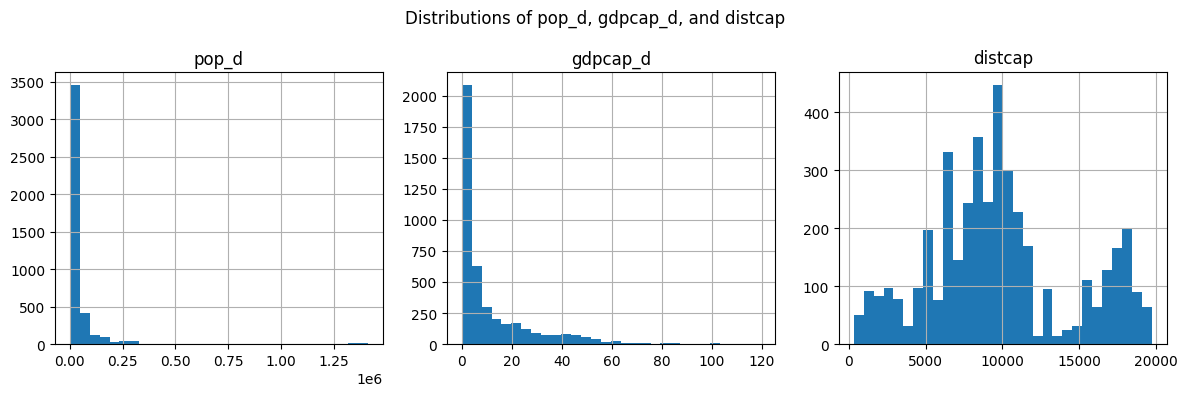

In [20]:
cols = ['pop_d', 'gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of pop_d, gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [21]:
# Standardizing non-geopolitical measures

df_final['log_pop_d'] = np.log1p(df_final['pop_d'])
df_final['log_gdpcap_d'] = np.log1p(df_final['gdpcap_d'])
scaler = StandardScaler()
df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']] = scaler.fit_transform(df_final[['log_pop_d', 'log_gdpcap_d', 'distcap']])

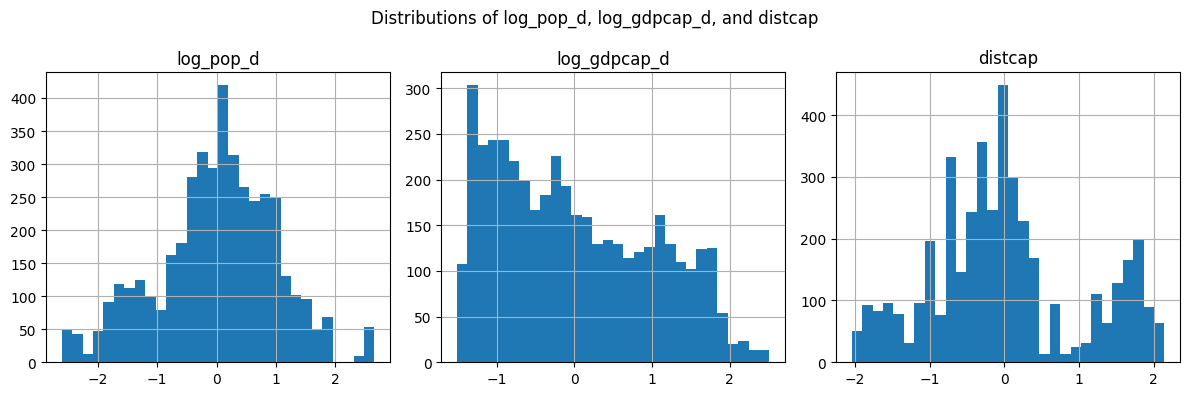

In [22]:
cols = ['log_pop_d', 'log_gdpcap_d', 'distcap']

df_final[cols].hist(bins=30, figsize=(12, 4), layout=(1, 3))
plt.suptitle("Distributions of log_pop_d, log_gdpcap_d, and distcap")
plt.tight_layout()
plt.show()

In [23]:
# Modeling
target = 'logallexports'
predictors = ['log_pop_d', 'log_gdpcap_d', 'distcap', 'geopolitical_closeness_index']
X = df_final[predictors]
y = df_final[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=222
)

In [24]:
# Training
model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=222
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Model Evaluation
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"\nEvaluation for target: {target}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


Evaluation for target: logallexports
RMSE: 1.0265
MAE: 0.7684
R²: 0.8604
MAPE: 0.0443


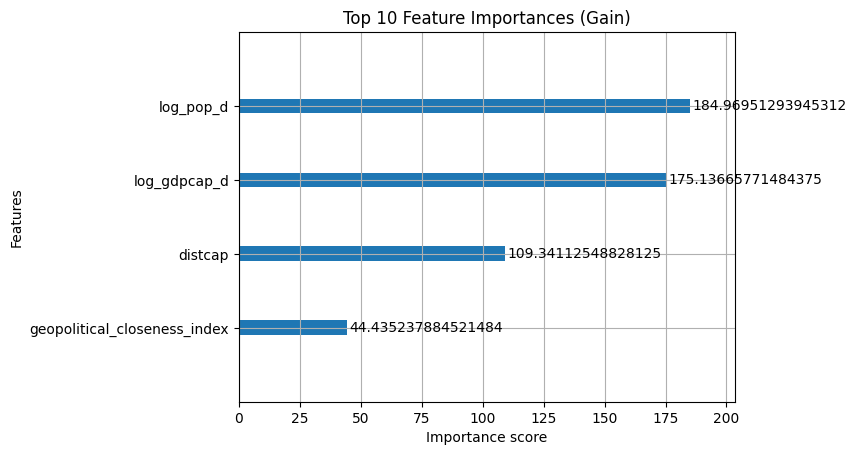

In [26]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.show()

In [27]:
import shap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

index_pos = list(X_test.columns).index('geopolitical_closeness_index')
feat_pos = X_test['geopolitical_closeness_index']
shap_pos = shap_values[:, index_pos]

corr_pos, p_val_pos = pearsonr(feat_pos, shap_pos)
print(f"Correlation for 'geopolitical_closeness_index': {corr_pos:.4f} (p={p_val_pos:.4f})")

Correlation for 'geopolitical_closeness_index': 0.7836 (p=0.0000)


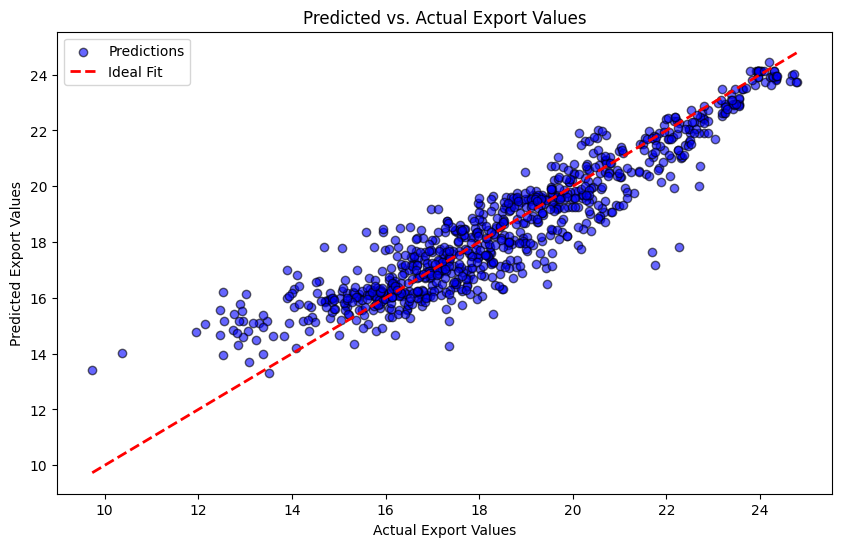

In [28]:
# Predict on the test set using your fitted model (XGBRegressor)
y_pred = model.predict(X_test)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel("Actual Export Values")
plt.ylabel("Predicted Export Values")
plt.title("Predicted vs. Actual Export Values")
plt.legend()
plt.show()

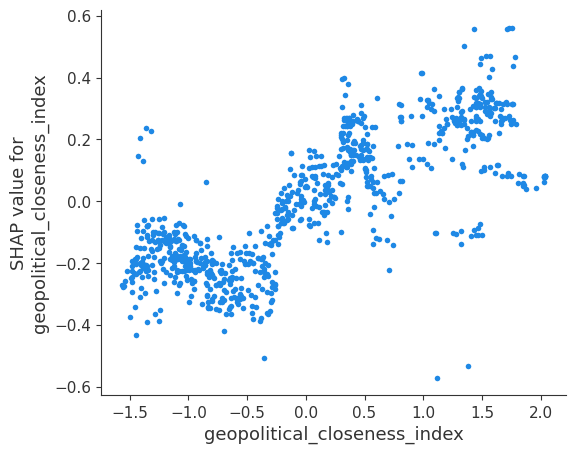

In [29]:
shap.dependence_plot('geopolitical_closeness_index', shap_values, X_test, interaction_index=None)